In [1]:
from pathlib import Path
from autoimplant.dataset import Autoimplant

dataset = Autoimplant(root=Path('/gpfs/gpfs0/a.shevtsov/data/trainset2021'), ids=[4, ])
complete_skull, defective_skull, complete_region, defective_region = dataset[0]

In [2]:
from dpipe.im.box import mask2bounding_box, limit_box, get_centered_box
import nrrd
import numpy as np

implant = nrrd.read(Path('/gpfs/gpfs0/a.shevtsov/data/trainset2021') / 'implant' / 'bilateral' / '{:03d}.nrrd'.format(4))[0]
center = mask2bounding_box(implant).sum(axis=0) // 2
box = limit_box(get_centered_box(center=center, box_size=np.array([384, 384, 320])), limit=(512, 512, 512))

In [3]:
from dpipe.io import load

model = 'saunet3d'

dices = list(load(f'/gpfs/gpfs0/a.shevtsov/experiments/autoimplant/{model}/test_metrics/dice_scores.json').values())
hus = list(load(f'/gpfs/gpfs0/a.shevtsov/experiments/autoimplant/{model}/test_metrics/hausdorff_distances.json').values())
bdices = list(load(f'/gpfs/gpfs0/a.shevtsov/experiments/autoimplant/{model}/test_metrics/border_dice_scores.json').values())

print('DSC  {:.3f} +- {:.3f}'.format(np.mean(dices), np.std(dices)))
print('HU   {:.3f} +- {:.3f}'.format(np.mean(hus), np.std(hus)))
print('bDSC {:.3f} +- {:.3f}'.format(np.mean(bdices), np.std(bdices)))

DSC  0.753 +- 0.032
HU   8.799 +- 2.990
bDSC 0.034 +- 0.010


In [4]:
ts_pred_region = load('/gpfs/gpfs0/a.shevtsov/experiments/autoimplant/unet3d/test_predictions/004.npy.gz')[..., 35:-35, :][0] > .5
ts_pred = defective_skull[0].copy()
ts_pred[tuple([slice(start, stop) for start, stop in zip(*box)])] = ts_pred_region
unet_pred = load('/gpfs/gpfs0/a.shevtsov/experiments/autoimplant/unet3d_full/test_predictions/004.npy.gz')[0]
saunet_pred = load('/gpfs/gpfs0/a.shevtsov/experiments/autoimplant/saunet3d/test_predictions/004.npy.gz')[0]

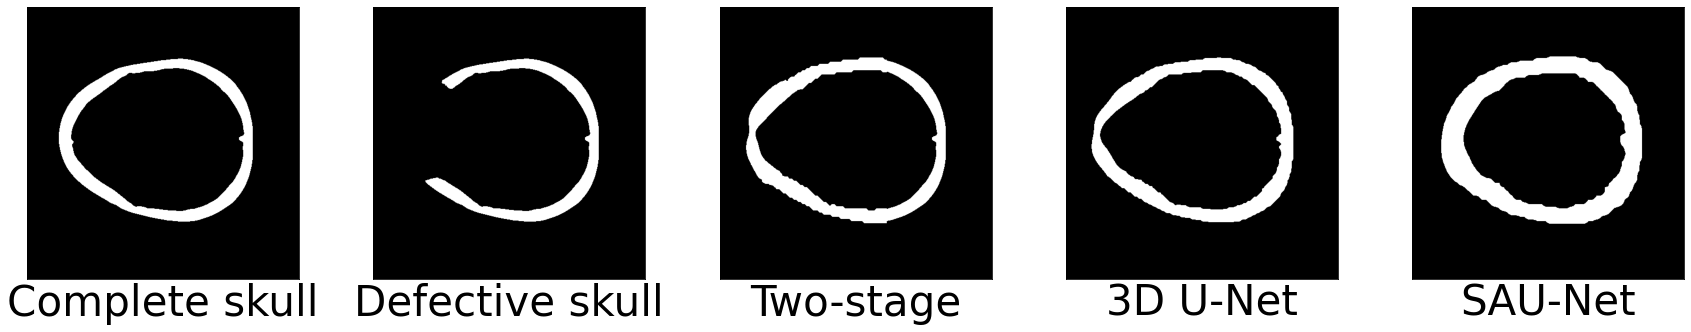

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 5, figsize=(30, 5))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

slice_ = 200

axs[0].imshow(complete_skull[0, ..., slice_], cmap='gray')
axs[1].imshow(defective_skull[0, ..., slice_], cmap='gray')
axs[2].imshow(ts_pred[..., slice_], cmap='gray')
axs[3].imshow(unet_pred[..., slice_] > .5, cmap='gray')
axs[4].imshow(saunet_pred[..., slice_] > .5, cmap='gray')

axs[0].set_xlabel('Complete skull', fontsize=42)
axs[1].set_xlabel('Defective skull', fontsize=42)
axs[2].set_xlabel('Two-stage', fontsize=42)
axs[3].set_xlabel('3D U-Net', fontsize=42)
axs[4].set_xlabel('SAU-Net', fontsize=42)

plt.show()